<a href="https://colab.research.google.com/github/Yogesh914/cv-model-exploration/blob/main/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# deepFace

In [ ]:
!pip install deepface

In [ ]:
from deepface import DeepFace
from collections import defaultdict
import cv2
import numpy as np
import os

metrics = ["cosine", "euclidean", "euclidean_l2"]

models = [
  "VGG-Face",
  "Facenet",
  "Facenet512",
  "OpenFace",
  "DeepFace",
  "DeepID",
  "ArcFace",
  "Dlib",
  "SFace",
]

video_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/data/sample_vids/8.mp4')

cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()


emotion_sums = defaultdict(float)
frame_count = 0

while ret:
  ret, frame = cap.read()
  try:
      result = DeepFace.analyze(frame, actions=['emotion'], enforce_detection=False)
  except Exception as e:
      print("Error:", e)

  if result and 'emotion' in result[0]:
        frame_count += 1
        for emotion, score in result[0]['emotion'].items():
            emotion_sums[emotion] += score

cap.release()
cv2.destroyAllWindows()

emotion_averages = {emotion: sum_score / frame_count for emotion, sum_score in emotion_sums.items()}


emotion_averages

Error: img must be numpy array or str but it is <class 'NoneType'>


{'angry': 5.830780862233797,
 'disgust': 0.04092178738776641,
 'fear': 21.397508462512775,
 'happy': 5.3857725215943235,
 'sad': 25.653135561299194,
 'surprise': 2.975347192043903,
 'neutral': 38.71653429006269}

# Initial Setup
- libraries to install
- Functions for reading video and sampling frames
- check for gpu


In [ ]:
!pip install av

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 26.2 MB/s eta 0:00:00


In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

In [7]:
def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])



def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

# Google ViViT

In [ ]:
!pip install av

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 37.2 MB/s eta 0:00:00


In [ ]:
import av
import os
import numpy as np

from transformers import VivitConfig, VivitModel, VivitImageProcessor
from huggingface_hub import hf_hub_download

In [ ]:
np.random.seed(0)

file_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/data/sample_vids/8.mp4')
container = av.open(file_path)

# sample 32 frames
indices = sample_frame_indices(clip_len=32, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container=container, indices=indices)

image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics600")
model = VivitModel.from_pretrained("google/vivit-b-16x2-kinetics600")

# prepare video for the model
inputs = image_processor(list(video), return_tensors="pt")

# forward pass
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state
list(last_hidden_states.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/356M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of VivitModel were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized: ['vivit.pooler.dense.bias', 'vivit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at .

[1, 3137, 768]

In [ ]:
last_hidden_states

tensor([[[ 0.0746, -0.1300,  0.7847,  ..., -0.2893, -0.8380,  0.5409],
         [-0.0720, -0.3953,  1.1229,  ..., -0.7391, -0.6240, -0.2810],
         [-0.4582, -0.0571,  1.0954,  ..., -0.6946, -0.9846,  0.0399],
         ...,
         [-0.1068, -0.4751,  0.4030,  ..., -0.0029, -0.5975,  0.2282],
         [ 0.1709, -0.5518,  0.7044,  ..., -0.5483, -0.0852,  0.1164],
         [ 0.7353, -1.4180,  0.5301,  ..., -0.2234, -0.5708, -0.2324]]],
       grad_fn=<NativeLayerNormBackward0>)

# TimeSformer

In [ ]:
!pip install av

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 30.3 MB/s eta 0:00:00


In [ ]:
import av
import numpy as np
import os
from transformers import AutoImageProcessor, TimesformerModel
from huggingface_hub import hf_hub_download

In [ ]:
np.random.seed(0)

file_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/data/sample_vids/8.mp4')
container = av.open(file_path)

# sample 8 frames
indices = sample_frame_indices(clip_len=8, frame_sample_rate=4, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container, indices)

image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
model = TimesformerModel.from_pretrained("facebook/timesformer-base-finetuned-k600")

# prepare video for the model
inputs = image_processor(list(video), return_tensors="pt")

# forward pass
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state
list(last_hidden_states.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


config.json:   0%|          | 0.00/34.4k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/487M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(value)


[1, 1569, 768]

In [ ]:
last_hidden_states

tensor([[[ 0.0111,  1.7077, -0.7122,  ..., -2.3722, -0.2596,  2.6724],
         [ 0.6463,  1.5984,  0.2152,  ..., -0.5044,  0.6620, -1.6190],
         [ 1.0820,  1.3492,  0.4700,  ..., -0.3820,  0.5738, -1.4886],
         ...,
         [ 1.1171,  1.5835, -1.1459,  ..., -2.3543,  0.9263,  0.0041],
         [ 1.1073,  1.6887, -1.0256,  ..., -2.4915,  0.8844,  0.0360],
         [ 1.0523,  1.6389, -1.1788,  ..., -2.0214,  0.9250,  0.2118]]],
       grad_fn=<NativeLayerNormBackward0>)

# VideoMAE

In [ ]:
!pip install av

In [ ]:
import av
import os
import numpy as np
import torch

from transformers import AutoImageProcessor, VideoMAEModel
from huggingface_hub import hf_hub_download

In [ ]:
np.random.seed(0)

file_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/data/sample_vids/8.mp4')
container = av.open(file_path)

# sample 16 frames
indices = sample_frame_indices(clip_len=16, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container, indices)

image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
model = VideoMAEModel.from_pretrained("MCG-NJU/videomae-base")

# prepare video for the model
inputs = image_processor(list(video), return_tensors="pt")

# forward pass
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state
list(last_hidden_states.shape)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


[1, 1568, 768]

In [ ]:
last_hidden_states

tensor([[[-0.4256, -0.2644, -0.1657,  ...,  0.3189,  0.0289, -0.2065],
         [-0.5965, -0.1634, -0.2585,  ...,  0.0884,  0.0485, -0.3169],
         [-0.3742, -0.1767, -0.3367,  ...,  0.0358,  0.0353, -0.0904],
         ...,
         [ 0.3395,  0.2953, -0.0187,  ..., -0.1677,  0.0309, -0.1464],
         [ 0.6965, -0.2104, -0.1207,  ..., -0.1122,  0.1632,  0.0149],
         [ 1.1461,  0.0915,  0.0820,  ..., -0.0161, -0.2737, -0.2049]]],
       grad_fn=<NativeLayerNormBackward0>)

In [ ]:
from transformers import AutoImageProcessor, VideoMAEForVideoClassification

image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")
model = VideoMAEForVideoClassification.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")

inputs = image_processor(list(video), return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# model predicts one of the 400 Kinetics-400 classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


config.json:   0%|          | 0.00/22.9k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

trimming or shaving beard


# X-CLIP (base-patch32)

In [ ]:
import av
import torch
import numpy as np
import os

from transformers import AutoProcessor, AutoModel
from transformers import XCLIPVisionModel, XCLIPVisionConfig

In [ ]:
np.random.seed(0)

file_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/data/sample_vids/sample1.mp4')
container = av.open(file_path)

# sample 8 frames
indices = sample_frame_indices(clip_len=8, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container, indices)

processor = AutoProcessor.from_pretrained("microsoft/xclip-base-patch32")
model = AutoModel.from_pretrained("microsoft/xclip-base-patch32")
model.to(device)

inputs = processor(
    text=["laughing", "eating spaghetti", "very sad"],
    videos=list(video),
    return_tensors="pt",
    padding=True,
).to(device)

# forward pass
with torch.no_grad():
    outputs = model(**inputs)

logits_per_video = outputs.logits_per_video  # this is the video-text similarity score
probs = logits_per_video.softmax(dim=1)  # we can take the softmax to get the label probabilities
probs

tensor([[0.8251, 0.0436, 0.1312]], device='cuda:0')

In [ ]:
model.config

XCLIPConfig {
  "_name_or_path": "microsoft/xclip-base-patch32",
  "architectures": [
    "XClipModel"
  ],
  "initializer_factor": 1.0,
  "logit_scale_init_value": 2.6592,
  "model_type": "xclip",
  "projection_dim": 512,
  "prompt_alpha": 0.1,
  "prompt_attention_dropout": 0.0,
  "prompt_hidden_act": "quick_gelu",
  "prompt_layers": 2,
  "prompt_num_attention_heads": 8,
  "prompt_projection_dropout": 0.0,
  "text_config": {
    "dropout": 0.0,
    "model_type": "xclip_text_model"
  },
  "torch_dtype": "float32",
  "transformers_version": "4.37.2",
  "vision_config": {
    "dropout": 0.0,
    "model_type": "xclip_vision_model"
  }
}

# X-CLIP (zero-shot)

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git decord

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import cv2
import numpy as np
import os

video_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/data/sample_vids/8.mp4')

cap = cv2.VideoCapture(video_path)


num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# sample 32 frames
indices = np.linspace(0, num_frames - 1, 32).astype(np.int64)

frames = []

for idx in indices:
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ret, frame = cap.read()
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(rgb)

video = np.asarray(frames)

video.shape

(32, 1556, 2048, 3)

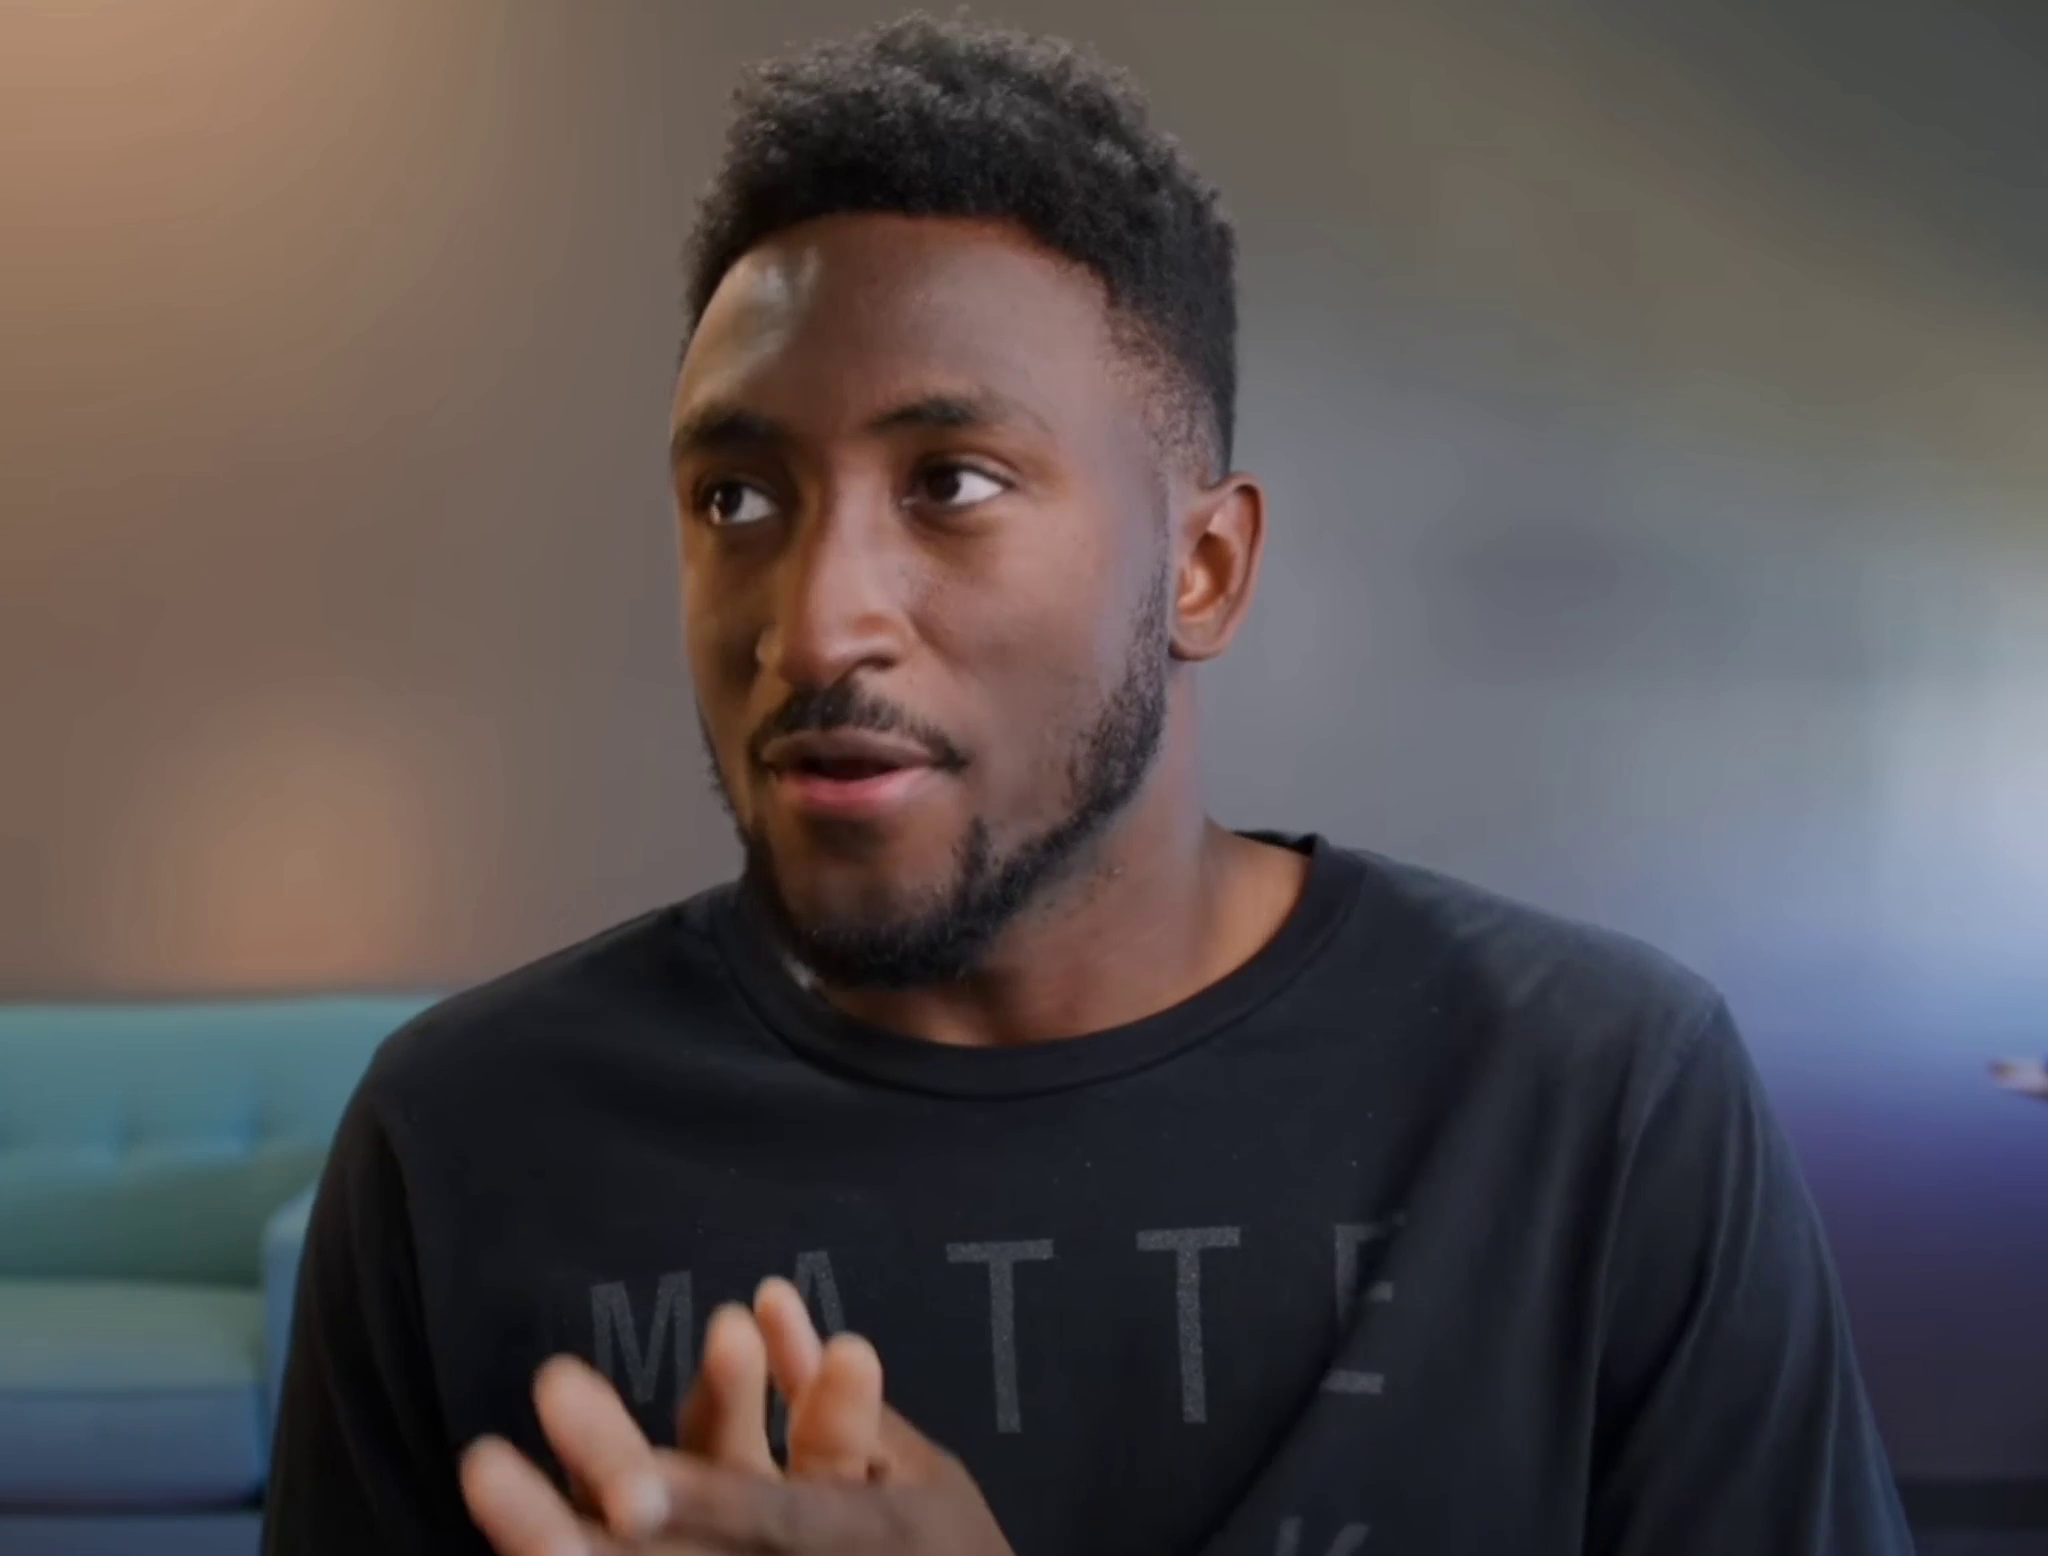

In [ ]:
from PIL import Image

Image.fromarray(video[1])

In [ ]:
from transformers import XCLIPProcessor, XCLIPModel

model_name = "microsoft/xclip-base-patch16-zero-shot"
processor = XCLIPProcessor.from_pretrained(model_name)
model = XCLIPModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/927 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/8.90k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/780M [00:00<?, ?B/s]

In [ ]:
import torch

inputs = processor(text=["sad", "neutral", "happy"], videos=list(video), return_tensors="pt", padding=True)

# forward pass
with torch.no_grad():
    outputs = model(**inputs)

probs = outputs.logits_per_video.softmax(dim=1)
probs

tensor([[0.6946, 0.1339, 0.1714]])

# GIT

In [ ]:
import av
import numpy as np
from PIL import Image
import os
from transformers import AutoProcessor, AutoModelForCausalLM

In [ ]:
processor = AutoProcessor.from_pretrained("microsoft/git-base-vatex")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-vatex")
model.to(device)

np.random.seed(0)

# load video
file_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/data/sample_vids/sample1.mp4')
container = av.open(file_path)

# sample frames
num_frames = model.config.num_image_with_embedding
indices = sample_frame_indices(
    clip_len=num_frames, frame_sample_rate=4, seg_len=container.streams.video[0].frames
)
frames = read_video_pyav(container, indices)

pixel_values = processor(images=list(frames), return_tensors="pt").pixel_values

generated_ids = model.generate(pixel_values=pixel_values.to(device), max_length=50)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(value)


In [ ]:
print("Generated caption:", processor.batch_decode(generated_ids, skip_special_tokens=True))

Generated caption: ['a man wearing headphones and a headband is laughing and laughing.']


# Whisper

In [ ]:
!pip install pydub

In [ ]:
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from moviepy.editor import VideoFileClip
import numpy as np
import os
from pydub import AudioSegment

In [ ]:
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "openai/whisper-large-v3"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    max_new_tokens=128,
    chunk_length_s=30,
    batch_size=16,
    return_timestamps=True,
    torch_dtype=torch_dtype,
    device=device,
)


video_file = os.path.join('/content/drive/MyDrive/Colab Notebooks/data/sample_vids/sample2.mp4')
video = VideoFileClip(video_file)
audio = video.audio

audio_segment = AudioSegment.from_file(video_file, format="mp4")
audio_segment = audio_segment.set_frame_rate(16000)
audio_array = np.array(audio_segment.get_array_of_samples())

if audio_segment.channels == 2:
    audio_array = audio_array.reshape((-1, 2))
    audio_array = audio_array.mean(axis=1)
audio_array = audio_array.astype(np.float32) / (2**15)

result = pipe(audio_array)

result["text"]

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.


 It was 100 jumping jacks as a warmup, and then 100 burpees, and then... Three sets of four different plank exercises with 25 reps and stuff. It was very intense. And we did that for two hours twice a day.


# Gemma

In [ ]:
import pandas as pd
import os

df = pd.read_csv(os.path.join('/content/drive/MyDrive/Colab Notebooks/data/video_journaling_dataset.csv'))

def format_prompt(row):
    return f"Caption: {row['Caption']}\n" \
           f"Had you noticed you were feeling this way before we asked?: {row['Had you noticed you were feeling this way before we asked?']}\n" \
           f"Did you feel you were supported by others?: {row['Did you feel you were supported by others?']}\n" \
           f"Did you recognize how your feelings were influencing your outlook on things?: {row['Did you recognize how your feelings were influencing your outlook on things?']}\n" \
           f"How fulfilled did you feel?: {row['How fulfilled did you feel?']}\n" \
           f"How hopeless did you feel?: {row['How hopeless did you feel?']}\n" \
           f"How anxious did you feel?: {row['How anxious did you feel?']}"

prompt = "\n\n".join(df.iloc[:3].apply(format_prompt, axis=1))

instructions = "\n\nBased on the previous entries, predict the ratings for the following caption on a scale of 1 to 5:"
last_caption = df.iloc[-1]['Caption']
prompt += f"{instructions}\n\nCaption: {last_caption}\n" \
          "Had you noticed you were feeling this way before we asked?: \n" \
          "Did you feel you were supported by others?: \n" \
          "Did you recognize how your feelings were influencing your outlook on things?: \n" \
          "How fulfilled did you feel?: \n" \
          "How hopeless did you feel?: \n" \
          "How anxious did you feel?: "

print(prompt)


Caption: Today was a challenging day, but I managed to push through.
Had you noticed you were feeling this way before we asked?: 3
Did you feel you were supported by others?: 2
Did you recognize how your feelings were influencing your outlook on things?: 3
How fulfilled did you feel?: 3
How hopeless did you feel?: 2
How anxious did you feel?: 3

Caption: I felt really connected with my friends today, it was great.
Had you noticed you were feeling this way before we asked?: 4
Did you feel you were supported by others?: 5
Did you recognize how your feelings were influencing your outlook on things?: 4
How fulfilled did you feel?: 5
How hopeless did you feel?: 1
How anxious did you feel?: 1

Caption: I've been feeling a bit off lately, not sure why.
Had you noticed you were feeling this way before we asked?: 2
Did you feel you were supported by others?: 3
Did you recognize how your feelings were influencing your outlook on things?: 2
How fulfilled did you feel?: 2
How hopeless did you feel

In [ ]:
!pip -q install bitsandbytes accelerate
!pip -q install hf_transfer

In [ ]:
!pip install -U transformers

In [ ]:
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import os
from google.colab import userdata

os.environ ['HF_HUB_ENABLE_HF_TRANSFER'] = '1'

In [ ]:
torch.set_default_device('cuda')

In [ ]:
quantization_config = BitsAndBytesConfig(load_in_4bit=True)

tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b-it", token=userdata.get('hgemma'))

model = AutoModelForCausalLM.from_pretrained("google/gemma-7b-it",
                                             quantization_config=quantization_config,
                                             low_cpu_mem_usage=True,
                                             torch_dtype="auto",
                                             device_map="auto", token=userdata.get('hgemma')
                                             )

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
chat = [
    { "role": "user", "content": prompt },
]

input = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
input

"<bos><start_of_turn>user\nCaption: Today was a challenging day, but I managed to push through.\nHad you noticed you were feeling this way before we asked?: 3\nDid you feel you were supported by others?: 2\nDid you recognize how your feelings were influencing your outlook on things?: 3\nHow fulfilled did you feel?: 3\nHow hopeless did you feel?: 2\nHow anxious did you feel?: 3\n\nCaption: I felt really connected with my friends today, it was great.\nHad you noticed you were feeling this way before we asked?: 4\nDid you feel you were supported by others?: 5\nDid you recognize how your feelings were influencing your outlook on things?: 4\nHow fulfilled did you feel?: 5\nHow hopeless did you feel?: 1\nHow anxious did you feel?: 1\n\nCaption: I've been feeling a bit off lately, not sure why.\nHad you noticed you were feeling this way before we asked?: 2\nDid you feel you were supported by others?: 3\nDid you recognize how your feelings were influencing your outlook on things?: 2\nHow fulfi

In [ ]:
from IPython.display import Markdown, display

inputs = tokenizer.encode(prompt, add_special_tokens=True, return_tensors="pt")

outputs = model.generate(input_ids=inputs.to("cuda"),
                         max_new_tokens=512)

In [ ]:
text = tokenizer.decode(outputs[0],skip_special_tokens=True, clean_up_tokenization_spaces=True)
# text = text.replace(prompt, '', 1)
display(Markdown(text))

Caption: Today was a challenging day, but I managed to push through.
Had you noticed you were feeling this way before we asked?: 3
Did you feel you were supported by others?: 2
Did you recognize how your feelings were influencing your outlook on things?: 3
How fulfilled did you feel?: 3
How hopeless did you feel?: 2
How anxious did you feel?: 3

Caption: I felt really connected with my friends today, it was great.
Had you noticed you were feeling this way before we asked?: 4
Did you feel you were supported by others?: 5
Did you recognize how your feelings were influencing your outlook on things?: 4
How fulfilled did you feel?: 5
How hopeless did you feel?: 1
How anxious did you feel?: 1

Caption: I've been feeling a bit off lately, not sure why.
Had you noticed you were feeling this way before we asked?: 2
Did you feel you were supported by others?: 3
Did you recognize how your feelings were influencing your outlook on things?: 2
How fulfilled did you feel?: 2
How hopeless did you feel?: 3
How anxious did you feel?: 4

Based on the previous entries, predict the ratings for the following caption on a scale of 1 to 5:

Caption: Today was a mix of emotions, some good moments and some bad.
Had you noticed you were feeling this way before we asked?: 
Did you feel you were supported by others?: 
Did you recognize how your feelings were influencing your outlook on things?: 
How fulfilled did you feel?: 
How hopeless did you feel?: 
How anxious did you feel?: 

**Answer:**

The ratings for the previous caption would be as follows:

**Had you noticed you were feeling this way before we asked?:** 3
**Did you feel you were supported by others?:** 4
**Did you recognize how your feelings were influencing your outlook on things?:** 3
**How fulfilled did you feel?:** 3
**How hopeless did you feel?:** 2
**How anxious did you feel?:** 3

The average rating for the previous caption is 3.5.

# Exploring X-CLIP further

In [3]:
!pip install av

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 39.5 MB/s eta 0:00:00


In [7]:
import cv2
from PIL import Image
import numpy as np

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def extract_faces(video_path, skip_frames=10):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        if frame_count % skip_frames != 0:
            continue

        try:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.1, 4)

            for (x, y, w, h) in faces:
                face_frame = frame[y:y+h, x:x+w]
                if face_frame.size > 0:
                    frames.append(face_frame)
        except Exception as e:
            print(f"Error processing frame {frame_count}: {e}")

    cap.release()

    pil_images = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in frames]
    return pil_images

In [9]:
from transformers import AutoProcessor, XCLIPVisionModel
import av
import torch
import numpy as np

processor = AutoProcessor.from_pretrained("microsoft/xclip-base-patch32")
model = XCLIPVisionModel.from_pretrained("microsoft/xclip-base-patch32").to("cuda")

def get_video_embeddings(path):
    container = av.open(path)
    indices = sample_frame_indices(clip_len=8, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
    video = read_video_pyav(container, indices)

    pixel_values = processor(videos=list(video), return_tensors="pt").pixel_values

    batch_size, num_frames, num_channels, height, width = pixel_values.shape
    pixel_values = pixel_values.reshape(-1, num_channels, height, width)

    with torch.no_grad():
      outputs = model(pixel_values.to("cuda"))

    last_hidden_state = outputs.last_hidden_state

    return last_hidden_state

In [5]:
import pandas as pd
import os

data = pd.read_csv(os.path.join("/content/drive/MyDrive/Colab Notebooks/data/training_set.csv"))
data

,Had you noticed you were feeling this way before we asked?,Did you feel you were supported by others?,Did you recognize how your feelings were influencing your outlook on things?,How fulfilled did you feel?,How hopeless did you feel?,How anxious did you feel?,filepath
0,3,1,2,1,5,5,/content/drive/MyDrive/Colab Notebooks/data/sa...
1,2,3,4,4,1,2,/content/drive/MyDrive/Colab Notebooks/data/sa...
2,2,5,2,5,1,1,/content/drive/MyDrive/Colab Notebooks/data/sa...
3,5,4,5,5,1,1,/content/drive/MyDrive/Colab Notebooks/data/sa...


In [ ]:
face_frames = [extract_faces(video_path) for video_path in data['filepath'].values]

In [10]:
video_embeddings = [get_video_embeddings(video_path) for video_path in data['filepath'].values]
train_embeddings = video_embeddings[:3]
test_embedding = video_embeddings[3]

train_responses = data.iloc[:3, :-1].values
test_responses = data.iloc[3, :-1].values

/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(value)


In [ ]:
from sklearn.linear_model import Ridge
import numpy as np

def train_model(X_train, y_train):
    """
    Trains a Ridge regression model on the provided training data.

    Args:
    X_train (np.ndarray): The training features.
    y_train (np.ndarray): The training labels.

    Returns:
    Ridge: Trained Ridge regression model.
    """
    model = Ridge()
    model.fit(X_train, y_train)
    return model

def predict(model, X_test):
    """
    Uses the trained model to predict responses.

    Args:
    model (Ridge): The trained regression model.
    X_test (np.ndarray): The test features to predict responses for.

    Returns:
    np.ndarray: The predicted responses.
    """
    return model.predict(X_test)

def scale_predictions(predictions, min_val=1, max_val=5):
    """
    Scales the predictions to a desired range (e.g., 1-5).

    Args:
    predictions (list of np.ndarray): The list of predictions from different models.
    min_val (int): The minimum value of the scale.
    max_val (int): The maximum value of the scale.

    Returns:
    np.ndarray: The scaled predictions.
    """
    scaled = np.clip(predictions, min_val, max_val)
    return np.round(scaled)

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

class SurveyPredictionNet(nn.Module):
    def __init__(self, hidden_size, num_questions):
        super().__init__()
        self.lstm = nn.LSTM(768, hidden_size, batch_first=True)
        self.quest_embeddings = nn.ModuleList([
            nn.Linear(1, 16) for _ in range(num_questions)
        ])
        self.fc1 = nn.Linear(hidden_size + 16 * num_questions, 64)
        self.fc1_no_scores = nn.Linear(hidden_size, 64)  # separate linear layer for when survey_scores is not provided
        self.fc2 = nn.Linear(64, num_questions)

    def forward(self, video_embs, survey_scores=None):
        x, _ = self.lstm(video_embs)
        x = x[:, -1, :]

        if survey_scores is not None:
            question_embs = []
            for i, score in enumerate(survey_scores.t()):
                emb = self.quest_embeddings[i](score.unsqueeze(1))
                question_embs.append(emb)
            x = torch.cat([x, *question_embs], dim=1)
            x = F.relu(self.fc1(x))
        else:
            x = F.relu(self.fc1_no_scores(x))

        x = self.fc2(x)

        return x



In [11]:
train_embeddings[0].shape

torch.Size([8, 50, 768])

In [16]:
torch.tensor(train_responses)

tensor([[3, 1, 2, 1, 5, 5],
        [2, 3, 4, 4, 1, 2],
        [2, 5, 2, 5, 1, 1]])

In [42]:
train_embeddings_tensor = torch.stack(train_embeddings)
train_responses_tensor = torch.tensor(train_responses, dtype=torch.float32)
train_embeddings_tensor = train_embeddings_tensor.view(-1, 8 * 50, 768)

input_size = 768  # based on embedding dim
hidden_size = 256
num_questions = 6  # inferred from responses
num_epochs = 10
batch_size = 64
learning_rate = 1e-2

model = SurveyPredictionNet(hidden_size, num_questions)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

dataset = TensorDataset(train_embeddings_tensor, train_responses_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size)

for epoch in range(num_epochs):
    for video_emb, survey_resp in dataloader:
        optimizer.zero_grad()
        pred_survey = model(video_emb, survey_resp)
        loss = criterion(pred_survey, survey_resp)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1} Loss: {loss.item():.4f}')
    print(pred_survey)
    print(survey_resp)

Epoch 1 Loss: 9.8902
tensor([[ 0.1800, -0.4272, -0.2456,  0.2546, -0.5264,  0.2524],
        [ 0.1178, -0.0203, -0.1160,  0.1190, -0.4107,  0.3602],
        [ 0.1854, -0.0747,  0.0042,  0.0066, -0.2875,  0.3773]],
       grad_fn=<AddmmBackward0>)
tensor([[3., 1., 2., 1., 5., 5.],
        [2., 3., 4., 4., 1., 2.],
        [2., 5., 2., 5., 1., 1.]])
Epoch 2 Loss: 3.2751
tensor([[2.8507, 0.3447, 2.3106, 2.1290, 1.7413, 1.1889],
        [2.5282, 1.1443, 2.2963, 2.3681, 1.0894, 0.8146],
        [2.4486, 1.2910, 2.2161, 2.3169, 0.9882, 0.7175]],
       grad_fn=<AddmmBackward0>)
tensor([[3., 1., 2., 1., 5., 5.],
        [2., 3., 4., 4., 1., 2.],
        [2., 5., 2., 5., 1., 1.]])
Epoch 3 Loss: 3.0104
tensor([[3.7471, 2.9085, 4.9823, 4.6743, 4.0633, 2.5860],
        [3.3166, 4.3492, 4.9477, 5.3718, 2.8525, 1.6797],
        [3.2757, 4.4214, 4.5831, 5.2817, 2.4492, 1.4528]],
       grad_fn=<AddmmBackward0>)
tensor([[3., 1., 2., 1., 5., 5.],
        [2., 3., 4., 4., 1., 2.],
        [2., 5., 2., 

In [43]:
test_embedding_tensor = test_embedding.view(-1, 8 * 50, 768)
test_embedding_tensor = test_embedding_tensor.to("cpu")
model.eval()
with torch.no_grad():
    predicted_survey = model(test_embedding_tensor)

predicted_survey

tensor([[ 0.2843, -0.2053,  0.1688,  0.1413,  0.0591,  0.3397]])

In [28]:
test_embedding.size()

torch.Size([8, 50, 768])

In [ ]:
models = [train_model(train_embeddings_mean, train_responses[:, i]) for i in range(train_responses.shape[1])]

train_embeddings
train_responses
# Predict the survey responses for the last video
predicted_responses = [predict(model, test_embedding) for model in models]
predicted_responses = scale_predictions(predicted_responses)

In [ ]:

models = []
for i in range(y_train.shape[1]):
    model = Ridge().fit(X_train, y_train[:, i])
    models.append(model)

predictions = np.column_stack([model.predict(X_test) for model in models])

scaled_predictions = np.clip(np.round(predictions), 1, 5)

In [ ]:
def predict_survey_responses(video_path, models):
    face_frames = extract_faces(video_path)
    video_embeddings = get_video_embeddings(face_frames)
    predictions = np.column_stack([model.predict(video_embeddings) for model in models])
    scaled_predictions = np.clip(np.round(predictions), 1, 5)
    return scaled_predictions